In [2]:

import csv
import json
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
from scipy import linalg as scipy_linalg

In [22]:
_OM2_BASE_DIR = '/Users/nicholaswatters/Desktop/grad_school/research/mehrdad/multi_prediction/phys'

# session = 'Elgar/2022-06-17'
session = 'Perle/2022-06-08'
probe_name = 'np_0'
kilosort_run_name = 'ks_3_output_v2'

session_dir = os.path.join(_OM2_BASE_DIR, 'phys_data', session)
spike_sorting_dir = os.path.join(session_dir, 'spike_sorting', probe_name)
print(f'spike_sorting_dir: {spike_sorting_dir}')
kilosort_dir = os.path.join(spike_sorting_dir, kilosort_run_name)
print(f'kilosort_dir: {kilosort_dir}')

mean_waveforms = np.load(os.path.join(kilosort_dir, 'mean_waveforms.npy'))
templates = np.load(os.path.join(kilosort_dir, 'templates.npy'))
templates_ind = np.load(os.path.join(kilosort_dir, 'templates_ind.npy'))
cluster_group = np.genfromtxt(
    os.path.join(kilosort_dir, 'cluster_group.tsv'),
    delimiter='\t',
    skip_header=True,
    dtype=str,
)

num_clusters = templates.shape[0]
print(f'num_clusters: {num_clusters}')

spike_sorting_dir: /Users/nicholaswatters/Desktop/grad_school/research/mehrdad/multi_prediction/phys/phys_data/Perle/2022-06-08/spike_sorting/np_0
kilosort_dir: /Users/nicholaswatters/Desktop/grad_school/research/mehrdad/multi_prediction/phys/phys_data/Perle/2022-06-08/spike_sorting/np_0/ks_3_output_v2
num_clusters: 386


In [23]:
def _plot_waveforms(w, half_channel_spread=20, title=''):
    # w is [timesteps, channels]
    if np.any(np.isnan(w)):
        return
    norm_w = w - np.mean(w, axis=0, keepdims=True)
    y_diff = np.max(norm_w, axis=0) - np.min(norm_w, axis=0)
    max_y_diff = np.max(y_diff)
    y_sep = 0.5 * max_y_diff
    max_y_diff_channel = np.argmax(y_diff)
    min_plot_channel = max(0, max_y_diff_channel - half_channel_spread)
    max_plot_channel = min(norm_w.shape[1] - 1, max_y_diff_channel + half_channel_spread)
    norm_w = norm_w[:, min_plot_channel:max_plot_channel]
    num_channels = norm_w.shape[1]
    fig, ax = plt.subplots(figsize=(4, 0.2 * num_channels))
    for i in range(num_channels):
        ax.plot(i * y_sep + norm_w[:, i])
    ax.set_ylim(-2 * y_sep, (i + 2) * y_sep)
    _ = ax.set_yticks(y_sep * np.arange(num_channels))
    _ = ax.set_yticklabels(range(min_plot_channel, max_plot_channel))
    ax.set_title(title)
    
    
def _get_peak_waveform_distrib(mean_waveforms):
    peak_channels = np.array([
        np.argmax(np.max(w, axis=0) - np.min(w, axis=0))
        for w in mean_waveforms
    ])
    return peak_channels

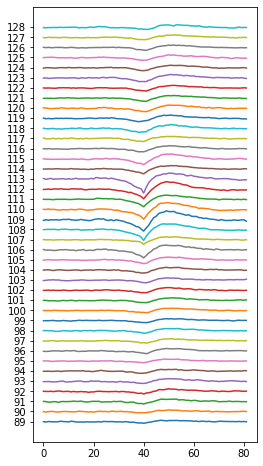

In [49]:
# peak_channels = _get_peak_waveform_distrib(mean_waveforms)
# plt.hist(peak_channels, bins=381)

_plot_waveforms(mean_waveforms[112])

In [9]:

def _get_dissimilarity_score(waveform_0, waveform_1):
    """Get dissimilarity score between two 1-channel waveforms.

    This measures the difference between the shapes of the two waveforms. It is
    invariant to the amplitude of the waveforms and temporal offsets of the
    waveforms.
    
    Args:
        waveform_0: Float array of size [timesteps]. Waveform on a single
            channel.
        waveform_1: Float array of size [timesteps]. Waveform on a single
            channel.

    Returns:
        dissimilarity_score: Float in [0, 1]. Lower means waveform shapes are
            more similar.
    """
    # First normalize the waveforms
    waveform_0 = waveform_0 - np.mean(waveform_0)
    waveform_0 = waveform_0 / np.sum(np.abs(waveform_0))
    waveform_1 = waveform_1 - np.mean(waveform_1)
    waveform_1 = waveform_1 / np.sum(np.abs(waveform_1))

    # Now compute the maximum difference between the two waveforms for every
    # temporal offset.
    w_first_deriv_circulant = scipy_linalg.circulant(waveform_0)
    diff_first_second = np.abs(w_first_deriv_circulant - waveform_1[:, np.newaxis])
    diff_fs = np.max(diff_first_second, axis=0)

    # The dissimilarity score is the difference between the min and max of these
    # differences.
    dissimilarity_score = np.min(diff_fs) / np.max(diff_fs)
    
    return dissimilarity_score

def _detect_noise_waveform(w,
                           max_top_2_channels_amplitude_ratio=5.,
                           max_top_2_channels_distance=10,
                           min_amplitude=5.,
                           max_top_2_dissimilarity_score=0.5,
                           max_waveform_spread=25):
    """Evaluate whether waveform is noise based on its shape.
    
    This is needed because Kilosort labels many noise clusters as mua.

    A waveform is considered noise if any of the following are true:
        * It has NaN values. This can happen if there were not enough spikes to
            compute the waveform.
        * If it is too sparse across channels, i.e. only appears on a single
            channel.
        * If it is significantly multimodal across channels.
        * If it's amplitude is too low.
        * If it exhibits significantly different shapes on different channels.
    See arguments for more details about these criteria.

    Args:
        w: Float array of size [timesteps, num_channels]. The waveform.
            Typically timesteps is 82 (that's Kilosort's default for templates),
            and for neuropixe num_channels is 384.
        max_top_2_channels_amplitude_ratio: Float. Maximum ratio of the
            amplitude of the waveform on the highest amplitude channel versus
            the second-highest amplitude channel. If this is exceeded, then the
            waveform is extremely sparse (essentially appearing on only one
            channel) so is noise. A conservative default that is unlikely to
            filter out real units is 5, though you may want a lower value to be
            less conservative.
        max_top_2_channels_distance: Maximum difference of the index of the
            highest amplitude channel versus the index of the second-highest
            amplitude channel. If this is exceeded, then the two highest
            amplitude channels are very far apart on the probe, so the waveform
            is multimodal in space and hence is noise. A conservative default
            that is unlikely to filter out real units is 10, though you may want
            a lower value to be less conservative.
        min_amplitude: Minimum amplitude of the waveform. If the amplitude on
            the highest-amplitude channel is less than this, then the unit is
            very low-amplitude and likely noise. A reasonable default for a
            typical neuropixel with ordinary impedance is 5.
        max_top_2_dissimilarity_score: Maximum dissimilarity between the
            waveform shapes on the highest amplitude channel and the
            second-highest amplitude channel. See _get_dissimilarity_score()
            above for the dissimilarity score. A conservative default that is
            unlikely to filter out real units is 0.5, though you may want a
            lower value to be less conservative and filter out more units.

    Returns:
        Noise: Bool. Whether the waveform is noise.
        Label: String. Label of the waveform if it is noise. If it is not noise,
            empty string.
    """
    if np.any(np.isnan(w)):
        return True, 'waveform_nan'
    
    # Sort the channel indices by amplitude of the waveform
    y_diff = np.abs(np.max(w, axis=0) - np.min(w, axis=0))
    top_channel_inds = np.argsort(y_diff)[::-1]
    
    # If amplitude radio for the highest amplitude channel vs second-highest
    # amplitude channel ratio is too high, waveform is too sparse across
    # channels, so label as noise
    first_max = y_diff[top_channel_inds[0]]
    second_max = y_diff[top_channel_inds[1]]
    if first_max > max_top_2_channels_amplitude_ratio * second_max:
        return True, 'waveform_sparsity'
    
    # If highest amplitude channel and second-highest amplitude channel are too
    # far apart on the probe, label as noise
    top_2_channel_sep = np.abs(top_channel_inds[0] - top_channel_inds[1])
    if top_2_channel_sep > max_top_2_channels_distance:
        return True, 'waveform_multimodal'
    
    # If amplitude is low, label as noise
    if first_max < min_amplitude:
        return True, 'waveform_amplitude'
    
    # If amplitude is too high across too many channels, label as noise because
    # the waveform is too spread out
    # Consider the mean of the top 3 channels to be the max amplitude
    max_amplitude = np.mean(y_diff[top_channel_inds[:3]])
    # Now find the spread of channels that have at least 60% that max
    high_amplitude_channels = np.argwhere(y_diff > 0.6 * max_amplitude)
    waveform_spread = (
        np.max(high_amplitude_channels) - np.min(high_amplitude_channels)
    )
    if waveform_spread > max_waveform_spread:
        return True, 'waveform_spread'
    
    # If dissimilarity score between highest amplitude channel and
    # second-highest amplitude channel is too high, label as noise.
    dissimilarity_score = _get_dissimilarity_score(
        w[:, top_channel_inds[0]], w[:, top_channel_inds[1]])
    if dissimilarity_score > max_top_2_dissimilarity_score:
        return True, 'waveform_dissimilarity'
    
    return False, ''


In [10]:
# for i in range(620, 630):
# for i in range(610, 620):
# for i in range(50, 100):
# for i in range(26, 31):
# for i in range(160, 200):
# for i in range(350, 400):
# for i in range(370, 380):
# for i in range(500, 510):
# for i in range(410, 420):

for i in range(0, num_clusters):
#     print(i)
    noise, reason = _detect_noise_waveform(mean_waveforms[i])
#     if bad or reason == 'dissimilar_chans':
#     if reason == 'dissimilar_chans':
#         _plot_waveforms(mean_waveforms[i], title=str(i) + ': ' + str(bad) + ' ' + reason)

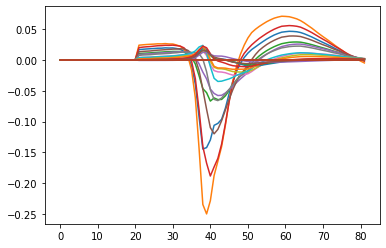

In [39]:
_ = plt.plot(templates[0])

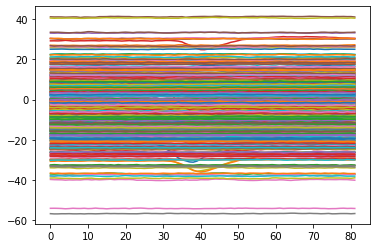

In [9]:
_ = plt.plot(mean_waveforms[0])

In [10]:
mean_waveforms[0].shape

(82, 384)